# SimFin Tutorial 05 - Data Hubs

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"I just have to type Y instead of Y-E-S ... Hey Miss-didn't-find-me-attractive-sexually-anymore, I just tripled my productivity!" &ndash; [The Simpsons](https://www.youtube.com/watch?v=R_rF4kcqLkI)

## Introduction

In the previous tutorials we saw how to download and load financial data from the SimFin server using the `sf.load` functions, how to resample and reindex the data using the `sf.resample` and `sf.reindex` functions, how to calculate growth-rates and stock-returns using the `sf.rel_change` and `sf.mean_log_change` functions, and finally how to combine all of this to calculate signals using functions like `sf.price_signals` and `sf.val_signals`.

Because we have to go through all these basic steps every time we want to work on the financial data, and this mostly consists of copy-pasting our previous code, the simfin package provides what we call *Data Hubs* to do most of the work for us.

The data-hub also uses disk-caching for its slow computations, so the results are automatically saved to disk and will be reloaded very quickly the next time the slow functions are called. The data-hub also ensures the disk-cache is updated whenever new datasets are downloaded from the SimFin server. The data-hub's functions are also RAM-cached, so the second time you call them, they return the results nearly instantly.

Altogether, the data-hub makes it much easier and faster to work with the financial data.

It is not strictly necessary for you to be familiar with the previous tutorials on the basics of simfin, but it is helpful because you would have a better understanding of what exactly the data-hub is doing.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.8.3'

## Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

In these examples, we are interested in US stock-market data for the tickers AAPL, AMZN and MSFT. We want to add a 60-day offset to the dates of the financial reports, to simulate the delay between the date of a financial report and when it was actually made available to the public. And finally we want to download the datasets from the SimFin server every 30 days, except for the share-prices which should be downloaded every 10 days.

In [6]:
# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = ['AAPL', 'AMZN', 'MSFT']

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

Using these settings, we can then create the data-hub object. This basically just creates and configures the data-hub. It does not load any data or perform any calculations at this point, so it returns nearly instantly.

In [7]:
%%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 19.6 µs


## Load Datasets

We can now use the data-hub to load financial datasets. This is very similar to the `sf.load` functions, except that we don't have to set the market-argument because that is already known by the data-hub. This is how we load the dataset with share-prices:

In [8]:
%%time
df_prices = hub.load_shareprices(variant='daily')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 12.8 s, sys: 953 ms, total: 13.7 s
Wall time: 13.9 s


In [9]:
df_prices.head()

SimFinId  Open   Low  High  Close  Adj. Close  Dividend  \
Ticker Date                                                                  
AAPL   2007-01-03    111052  3.08  2.92  3.09   2.99        2.57       NaN   
       2007-01-04    111052  3.00  2.99  3.07   3.06        2.63       NaN   
       2007-01-05    111052  3.06  3.01  3.08   3.04        2.61       NaN   
       2007-01-08    111052  3.07  3.05  3.09   3.05        2.62       NaN   
       2007-01-09    111052  3.09  3.04  3.32   3.31        2.84       NaN   

                      Volume  Shares Outstanding  
Ticker Date                                       
AAPL   2007-01-03   44225700                 NaN  
       2007-01-04   30259300                 NaN  
       2007-01-05   29812200                 NaN  
       2007-01-08   28468100                 NaN  
       2007-01-09  119617800                 NaN

Note what happens if we call the exact same function again with the exact same argument - it returns the exact same result almost instantly. This is because the data-hub uses a RAM-cache for most of its functions, so the DataFrame is just taken from RAM instead of being reloaded from disk.

In [10]:
%%time
df_prices = hub.load_shareprices(variant='daily')

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 23.6 µs


We can also use the data-hub to load other datasets such as the TTM Income Statements:

In [11]:
%%time
df_income_ttm = hub.load_income(variant='ttm')

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 361 ms, sys: 0 ns, total: 361 ms
Wall time: 358 ms


In [12]:
df_income_ttm.head()

SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
AAPL   2001-03-31     111052      USD         2001            Q2   2001-05-12   
       2001-06-30     111052      USD         2001            Q3   2001-08-13   
       2001-09-30     111052      USD         2001            Q4   2001-11-11   
       2001-12-31     111052      USD         2002            Q1   2002-02-11   
       2002-03-31     111052      USD         2002            Q2   2002-05-14   

                   Restated Date  Shares (Basic)  Shares (Diluted)  \
Ticker Report Date                                                   
AAPL   2001-03-31     2002-05-14    2.420866e+10      2.490018e+10   
       2001-06-30     2002-08-09    2.420866e+10      2.490018e+10   
       2001-09-30     2003-12-19    2.420866e+10      2.490018e+10   
       2001-12-31     2003-02-10    2.420866e+10      2.490018e+10   
       2002-03-31     2003-05-13    2.420866e+10      2.490018e+10   

                         Revenue  Cost of Revenue  ...  \
Ticker Report Date                                 ...   
AAPL   2001-03-31   6.133000e+09    -4.759000e+09  ...   
       2001-06-30   5.783000e+09    -4.518000e+09  ...   
       2001-09-30   5.363000e+09    -4.128000e+09  ...   
       2001-12-31   5.731000e+09    -4.053000e+09  ...   
       2002-03-31   5.795000e+09    -4.093000e+09  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
AAPL   2001-03-31                   246000000.0                    NaN   
       2001-06-30                   239000000.0                    NaN   
       2001-09-30                   217000000.0                    NaN   
       2001-12-31                   184000000.0                    NaN   
       2002-03-31                   146000000.0                    NaN   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
AAPL   2001-03-31                     70000000              196000000.0   
       2001-06-30                    -63000000              146000000.0   
       2001-09-30                   -116000000               64000000.0   
       2001-12-31                    291000000                5000000.0   
       2002-03-31                    289000000                      0.0   

                    Pretax Income (Loss)  Income Tax (Expense) Benefit, Net  \
Ticker Report Date                                                            
AAPL   2001-03-31              266000000                        -60000000.0   
       2001-06-30               83000000                        -16000000.0   
       2001-09-30              -52000000                         15000000.0   
       2001-12-31              296000000                        -88000000.0   
       2002-03-31              289000000                        -84000000.0   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
AAPL   2001-03-31                                  206000000   
       2001-06-30                                   67000000   
       2001-09-30                                  -37000000   
       2001-12-31                                  208000000   
       2002-03-31                                  205000000   

                    Net Extraordinary Gains (Losses)  Net Income  \
Ticker Report Date                                                 
AAPL   2001-03-31                                NaN   206000000   
       2001-06-30                                NaN    67000000   
       2001-09-30                                NaN   -37000000   
       2001-12-31                                NaN   208000000   
       2002-03-31                                NaN   205000000   

                    Net Incom

Again we see that the function returns nearly instantly when we call it the second time, provided the argument is exactly the same, because then the DataFrame is merely taken from the RAM-cache instead of being reloaded from disk:

In [13]:
%%time
df_income_ttm = hub.load_income(variant='ttm')

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 13.1 µs


## RAM-Cache Warning

Because the data-hub uses a RAM-cache for its functions, it means that you should **NEVER** modify the DataFrames returned by the data-hub's functions, because that would modify the DataFrames stored in the RAM-cache, which may interfere with the data-hubs' other functions that use the same data. If you want to modify the DataFrames returned by the data-hub, you should **ALWAYS** make a copy first!

In [14]:
# Load the share-prices.
df_prices = hub.load_shareprices(variant='daily')

# Now we want to set the Closing share-prices to zero.

# This is BAD because it changes the contents of the RAM-cache
# inside the hub-object.
# df_prices[CLOSE] = 0.0

# This is fine because it only changes a copy of the data, so
# the RAM-cache inside the hub-object remains unchanged.
df_prices2 = df_prices.copy()
df_prices2[CLOSE] = 0.0

Although it is possible to clear the RAM-cache for the data-hubs' functions using the following command, it is recommended that you simply create a new data-hub and start over, if you accidentally modified any of the DataFrames returned by the data-hub.

In [15]:
# Clear the RAM-cache for the function.
# hub.load_shareprices.cache_clear()

## Calculate Signals

The benefits of the data-hub are much greater for the functions that calculate signals such as valuation ratios, moving averages of the share-prices, sales and earnings growth, etc. The data-hub makes the syntax much simpler for these functions, because you only need to call a single function, which then loads the required datasets (or takes them from the RAM-cache if they have already been loaded), and then passes the datasets along with other relevant arguments to the lower-level functions that perform the actual computations.

Furthermore, the data-hub also uses a disk-cache for its slow functions, so the results are automatically saved to a file on disk, which can be reloaded very quickly the next time you call the function. The cache-files are automatically updated by recomputing the slow functions, whenever the relevant datasets are downloaded again from the SimFin server.

The disk-cache works in addition to the RAM-cache, so the data-hub uses two layers of caching to return the data as fast as possible, when the data does not have to be reloaded or calculated again.

The filenames used by the disk-cache are automatically set from all the arguments to the data-hub and its functions, using a hashing-function that creates a short but nearly unique ID code, so the cache-files are kept separate when you call the same function but with different arguments.

### Price Signals

This is how easily we may calculate price signals such as Moving Averages. Note that the function finished very quickly because we are only using data for 3 stocks, so there is no need for the disk-cache here. But if we had not specified a list of tickers when creating the data-hub object, this function would calculate the signals for thousands of stocks, which takes a while to compute, so the disk-cache is often very useful.

In [16]:
%%time
df_price_signals = hub.price_signals()

Cache-file 'price_signals-d03458cf.pickle' not on disk.
- Running function price_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 60.3 ms, sys: 343 µs, total: 60.6 ms
Wall time: 59.2 ms


In [17]:
df_price_signals.head()

EMA      MACD  MACD-EMA  MAVG 20  MAVG 200
Ticker Date                                                       
AAPL   2007-01-03  2.990000  0.000000  0.000000      NaN       NaN
       2007-01-04  3.026750  0.001571  0.000873      NaN       NaN
       2007-01-05  3.031615  0.001381  0.001081      NaN       NaN
       2007-01-08  3.036923  0.001622  0.001264      NaN       NaN
       2007-01-09  3.102978  0.012065  0.004477      NaN       NaN

### Volume Signals

This is how easily we may calculate the volume signals:

In [18]:
%%time
df_vol_signals = hub.volume_signals(window=20)

Cache-file 'volume_signals-f730379a.pickle' not on disk.
- Running function volume_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 94.5 ms, sys: 198 µs, total: 94.7 ms
Wall time: 93.2 ms


If we call the same function with a different argument, then the data-hub automatically changes the cache-name so as to keep the different results in separate cache-files:

In [19]:
%%time
df_vol_signals2 = hub.volume_signals(window=30)

Cache-file 'volume_signals-5c7ced78.pickle' not on disk.
- Running function volume_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 72.7 ms, sys: 908 µs, total: 73.6 ms
Wall time: 71.2 ms


In [20]:
df_vol_signals.dropna(how='all').head()

Relative Volume  Volume Market-Cap  Volume Turnover
Ticker Date                                                           
AAPL   2007-01-31        -0.463248       1.565959e+08         0.002007
       2007-02-01        -0.695482       1.535787e+08         0.001965
       2007-02-02        -0.753584       1.523119e+08         0.001948
       2007-02-05        -0.814985       1.508815e+08         0.001929
       2007-02-06        -0.416573       1.511862e+08         0.001934

### Financial Signals

The following shows how easily we may calculate financial signals such as Current Ratio, Debt Ratio, Net Profit Margin, etc. The function's argument `variant` determines the frequency of the resulting data-points:

- `variant=daily` means the result has daily data-points for the same dates as the share-prices. By default this uses forward-filling with the last-known values, but this can be changed with the `fill_method` argument when constructing the data-hub.

- `variant=latest` means the result only has data-points for the last date of the share-prices. This is much faster to compute than daily data-points.

- `variant=quarterly` means the result has 4 data-points per year for the same dates as the company's quarterly financial reports (with the report date shifted if the `offset` argument was given when the data-hub object was created).

In [21]:
%%time
df_fin_signals_daily = hub.fin_signals(variant='daily')

Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-c549b5bd.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 735 ms, sys: 4.48 ms, total: 740 ms
Wall time: 737 ms


In [22]:
df_fin_signals_daily.dropna(how='all').head()

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
AAPL   2007-01-03                           0.024104        1.122639   
       2007-01-04                           0.024104        1.122639   
       2007-01-05                           0.024104        1.122639   
       2007-01-08                           0.024104        1.122639   
       2007-01-09                           0.024104        1.122639   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
AAPL   2007-01-03               3.044444       2.251901         NaN   
       2007-01-04               3.044444       2.251901         NaN   
       2007-01-05               3.044444       2.251901         NaN   
       2007-01-08               3.044444       2.251901         NaN   
       2007-01-09               3.044444       2.251901         NaN   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
AAPL   2007-01-03             -0.0             0.289827                NaN   
       2007-01-04             -0.0             0.289827                NaN   
       2007-01-05             -0.0             0.289827                NaN   
       2007-01-08             -0.0             0.289827                NaN   
       2007-01-09             -0.0             0.289827                NaN   

                   Inventory Turnover  Log Revenue  \
Ticker Date                                          
AAPL   2007-01-03           71.537037    10.285895   
       2007-01-04           71.537037    10.285895   
       2007-01-05           71.537037    10.285895   
       2007-01-08           71.537037    10.285895   
       2007-01-09           71.537037    10.285895   

                   Net Acquisitions / Total Assets  Net Profit Margin  \
Ticker Date                                                             
AAPL   2007-01-03                             -0.0           0.102977   
       2007-01-04                             -0.0           0.102977   
       2007-01-05                             -0.0           0.102977   
       2007-01-08                             -0.0           0.102977   
       2007-01-09                             -0.0           0.102977   

                   Quick Ratio  R&D / Gross Profit  R&D / Revenue  \
Ticker Date                                                         
AAPL   2007-01-03     1.763464            0.127188       0.036863   
       2007-01-04     1.763464            0.127188       0.036863   
       2007-01-05     1.763464            0.127188       0.036863   
       2007-01-08     1.763464            0.127188       0.036863   
       2007-01-09     1.763464            0.127188       0.036863   

                   Return on Assets  Return on Equity  \
Ticker Date                                             
AAPL   2007-01-03          0.115606          0.199219   
       2007-01-04          0.115606          0.199219   
       2007-01-05          0.115606          0.199219   
       2007-01-08          0.115606          0.199219   
       2007-01-09          0.115606          0.199219   

                   Return on Research Capital  Share Buyback / FCF  
Ticker Date                                                         
AAPL   2007-01-03                     7.86236             0.024104  
       2007-01-04                     7.86236             0.024104  
       2007-01-05                     7.86236             0.024104  
       2007-01-08                     7.86236             0.024104  
       2007-01-09                     7.86236             0.024104

### Growth Signals

The following shows how easily we may calculate growth-signals. This function also takes the argument `variant` which has the same meaning as for the `fin_signals` function above. For example, when `variant=quarterly` it creates 4 data-points per yer:

In [23]:
%%time
df_growth_signals_qrt = hub.growth_signals(variant='quarterly')

Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-70589cd4.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 1.11 s, sys: 7.66 ms, total: 1.12 s
Wall time: 1.12 s


In [24]:
df_growth_signals_qrt.dropna(how='all').head()

Assets Growth  Assets Growth QOQ  Assets Growth YOY  \
Ticker Report Date                                                        
AAPL   2000-11-29             NaN           0.000000                NaN   
       2001-03-01             NaN          -0.114949                NaN   
       2001-05-30             NaN           0.000000                NaN   
       2001-08-29             NaN           0.000000          -0.114949   
       2001-11-29             NaN           0.000000          -0.114949   

                    Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Report Date                                                              
AAPL   2000-11-29               NaN            -0.150000                  NaN   
       2001-03-01               NaN            -2.217647                  NaN   
       2001-05-30               NaN            -1.207729                  NaN   
       2001-08-29               NaN             0.418605            -0.695000   
       2001-11-29               NaN             0.081967            -0.611765   

                    FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Report Date                                                             
AAPL   2000-11-29          NaN       -0.450893             NaN           NaN   
       2001-03-01          NaN       -1.284553             NaN           NaN   
       2001-05-30          NaN        0.742857             NaN           NaN   
       2001-08-29          NaN        0.032787       -1.281250           NaN   
       2001-11-29          NaN       -2.777778       -0.089431           NaN   

                    Sales Growth QOQ  Sales Growth YOY  
Ticker Report Date                                      
AAPL   2000-11-29           0.024658               NaN  
       2001-03-01          -0.461497               NaN  
       2001-05-30           0.421053               NaN  
       2001-08-29           0.030748         -0.191781  
       2001-11-29          -0.016949         -0.224599

If we change the argument to `variant='daily'` then we get daily data-points where the growth-rates have been forward-filled from the last-known values (this may be changed by setting the argument `fill_method` when constructing the data-hub object). Note that the cache-filename is different to keep the files separate.

In [25]:
%%time
df_growth_signals_daily = hub.growth_signals(variant='daily')

Cache-file 'growth_signals-c549b5bd.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 114 ms, sys: 143 µs, total: 114 ms
Wall time: 111 ms


In [26]:
df_growth_signals_daily.dropna(how='all').head()

Assets Growth  Assets Growth QOQ  Assets Growth YOY  \
Ticker Date                                                              
AAPL   2007-01-03       0.494008                0.0           0.494008   
       2007-01-04       0.494008                0.0           0.494008   
       2007-01-05       0.494008                0.0           0.494008   
       2007-01-08       0.494008                0.0           0.494008   
       2007-01-09       0.494008                0.0           0.494008   

                   Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
AAPL   2007-01-03         0.497741             0.148305             0.278302   
       2007-01-04         0.497741             0.148305             0.278302   
       2007-01-05         0.497741             0.148305             0.278302   
       2007-01-08         0.497741             0.148305             0.278302   
       2007-01-09         0.497741             0.148305             0.278302   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
AAPL   2007-01-03   -0.325275        0.145455        0.344512      0.386476   
       2007-01-04   -0.325275        0.145455        0.344512      0.386476   
       2007-01-05   -0.325275        0.145455        0.344512      0.386476   
       2007-01-08   -0.325275        0.145455        0.344512      0.386476   
       2007-01-09   -0.325275        0.145455        0.344512      0.386476   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
AAPL   2007-01-03          0.106865          0.315117  
       2007-01-04          0.106865          0.315117  
       2007-01-05          0.106865          0.315117  
       2007-01-08          0.106865          0.315117  
       2007-01-09          0.106865          0.315117

### Valuation Signals

The following shows how easily we may calculate valuation signals such as P/E and P/Sales ratios. This requires several datasets, but most of them have already been loaded by the data-hub in the function-calls we ran above, so the datasets are merely taken from the RAM-cache instead of being loaded again.

By setting `variant='latest'` we only calculate the valuation signals for the latest day of the share-prices. This is much faster than calculating the signals for daily data-points, and is useful e.g. when making a stock-screener:

In [27]:
%%time
df_val_signals_latest = hub.val_signals(variant='latest')

Dataset "us-shareprices-latest" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-cac8146c.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 58.6 ms, sys: 471 µs, total: 59.1 ms
Wall time: 74.7 ms


In [28]:
df_val_signals_latest.head()

,,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value
Ticker,Date,,,,,,,,,,,
AAPL,2021-09-17,0.005424,0.022555,0.027683,2.590295e+12,27.845147,44.336143,36.123822,-24.670179,-18.957561,9.458567,35.835959
AMZN,2021-09-17,NaN,0.007515,-0.003068,1.753766e+12,24.565651,133.062700,-325.978881,-23.803121,-16.961728,5.450169,23.786979
MSFT,2021-09-17,0.006570,0.019220,0.019634,2.303901e+12,16.875059,52.029114,50.932953,-2109.799643,-107.037468,16.109507,19.474415


We may also calculate the valuation signals for daily data-points, simply by setting the argument `variant='daily'`:

In [29]:
%%time
df_val_signals_daily = hub.val_signals(variant='daily')

Cache-file 'val_signals-a6127cfd.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 163 ms, sys: 4.46 ms, total: 167 ms
Wall time: 159 ms


In [30]:
df_val_signals_daily.dropna(how='all').head()

Dividend Yield  Earnings Yield  FCF Yield    Market-Cap  \
Ticker Date                                                                  
AAPL   2007-01-03             NaN        0.026715   0.020617  7.445153e+10   
       2007-01-04             NaN        0.026104   0.020146  7.619454e+10   
       2007-01-05             NaN        0.026276   0.020278  7.569654e+10   
       2007-01-08             NaN        0.026190   0.020212  7.594554e+10   
       2007-01-09             NaN        0.024133   0.018624  8.241958e+10   

                     P/Cash        P/E      P/FCF     P/NCAV   P/NetNet  \
Ticker Date                                                               
AAPL   2007-01-03  7.364147  37.431637  48.502623  10.215632  18.786658   
       2007-01-04  7.536552  38.307963  49.638136  10.454794  19.226480   
       2007-01-05  7.487293  38.057584  49.313704  10.386462  19.100816   
       2007-01-08  7.511923  38.182774  49.475920  10.420628  19.163648   
       2007-01-09  8.152283  41.437699  53.693539  11.308944  20.797270   

                    P/Sales  Price to Book Value  
Ticker Date                                       
AAPL   2007-01-03  3.854596             7.457084  
       2007-01-04  3.944838             7.631665  
       2007-01-05  3.919054             7.581784  
       2007-01-08  3.931946             7.606724  
       2007-01-09  4.267128             8.255167

## Calculate Returns

The data-hub also provides functions for easily calculating stock-returns for different investment durations. Let us first calculate the annualized future stock-returns for all 3-year investment periods.

In [31]:
# Name of the new Pandas Series with the stock-returns.
TOTAL_RETURN_3Y = 'Total Return 3-Year'

In [32]:
%%time
df_returns_3y = hub.returns(name=TOTAL_RETURN_3Y, years=3,
                            future=True, annualized=True)

Cache-file 'rel_change-2ab9d7a6.pickle' not on disk.
- Running function rel_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 8.3 ms, sys: 20 µs, total: 8.32 ms
Wall time: 6.7 ms


For example, the calculated return for AAPL on 2007-01-03 is 0.359641, which means that between 2007-01-03 and 2010-01-03 (or the closest trading-day), the annualized return was about 35.96% per year. This is the so-called Total Return which assumes dividends are reinvested without having to pay any taxes.

In [33]:
df_returns_3y.loc['AAPL']['2007-01-03':'2007-01-09']

Date
2007-01-03    0.359674
2007-01-04    0.356181
2007-01-05    0.360327
2007-01-08    0.351666
2007-01-09    0.315143
Name: Total Return 3-Year, dtype: float64

We can also plot these 3-year annualized returns for the AAPL stock:

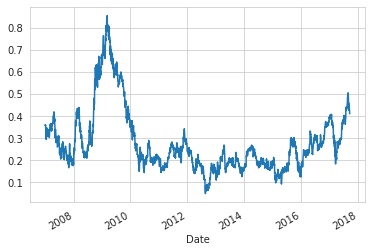

In [34]:
df_returns_3y.loc['AAPL'].dropna().plot(grid=True)

### Mean-Log Returns

It is often useful to consider the average returns e.g. over 1-3 year periods. It is much faster to compute the mean-log returns, and the results are close to the mean returns.

In [35]:
# Name of the new Pandas Series with the stock-returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [36]:
%%time
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         min_years=1, max_years=3,
                         future=True, annualized=True)

Cache-file 'mean_log_change-257ab99e.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 53.4 ms, sys: 87 µs, total: 53.5 ms
Wall time: 52.4 ms


For ticker AAPL, the mean-log return was 0.277523 for all 1-3 year investment periods between 2007-01-03 and 2010-01-03. This means that if you had bought AAPL stock on 2007-01-03 and sold them somewhere between 2008-01-03 and 2010-01-03, then on average you would have made roughly 28% per year, depending on exactly when you had sold the stocks in this 1-3 year period. Note that the mean-log return corresponds roughly to the (non-log) mean returns for values in this range.

In [37]:
df_returns_1_3y.loc['AAPL']['2007-01-03':'2007-01-09']

Date
2007-01-03    0.277665
2007-01-04    0.264770
2007-01-05    0.268767
2007-01-08    0.266535
2007-01-09    0.222022
Name: Total Return 1-3 Years, dtype: float64

We can also plot the mean-log returns for 1-3 year investment periods for the AAPL stock:

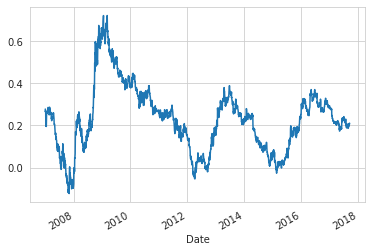

In [38]:
df_returns_1_3y.loc['AAPL'].dropna().plot(grid=True)

## Combine Signals and Returns

Let us now combine the stock-returns and the signals we are interested in, into a single DataFrame that is easier to work with:

In [39]:
# List of all the DataFrames with different signals.
dfs = [df_price_signals, df_fin_signals_daily,
       df_growth_signals_daily, df_val_signals_daily]

# Combine all the signal DataFrames into a single DataFrame.
df_all_signals = pd.concat(dfs, axis=1)

# DataFrame with the signals we are interested in, for example.
signals = [PE, PSALES, CURRENT_RATIO, MAVG_20]
df_signals = df_all_signals[signals]

# DataFrame with the signals and stock-returns.
dfs = [df_signals, df_returns_3y, df_returns_1_3y]
df_combined = pd.concat(dfs, axis=1)

# Remove rows with any NaN values.
df_combined = df_combined.dropna(how='any')

In [40]:
df_combined.head()

P/E   P/Sales  Current Ratio  MAVG 20  \
Ticker Date                                                      
AAPL   2007-01-31  38.307963  3.944838       2.251901   3.1745   
       2007-02-01  37.932395  3.906163       2.251901   3.1765   
       2007-02-02  37.932395  3.906163       2.251901   3.1750   
       2007-02-05  37.556827  3.867488       2.251901   3.1730   
       2007-02-06  37.682016  3.880379       2.251901   3.1710   

                   Total Return 3-Year  Total Return 1-3 Years  
Ticker Date                                                     
AAPL   2007-01-31             0.308342                0.265802  
       2007-02-01             0.319275                0.272405  
       2007-02-02             0.322215                0.272741  
       2007-02-05             0.334661                0.279497  
       2007-02-06             0.316740                0.277842

We can then plot e.g. the P/Sales ratios versus the future 1-3 year stock-returns:

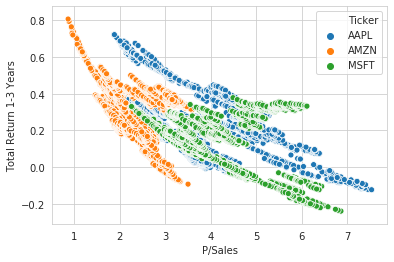

In [41]:
sns.scatterplot(x=PSALES, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_combined.reset_index())

### NumPy Arrays

If you want to use the signals and stock-returns with functions that accept NumPy arrays instead of Pandas DataFrames, it is very easy to convert from Pandas to NumPy, because Pandas uses NumPy internally:

In [42]:
# Get the numpy array with the signals and stock-returns
# from the Pandas DataFrame.
arr = df_combined.values

# Number of signals in the DataFrame.
num_signals = 4

# Numpy array with the signals.
arr_signals = arr[:, :num_signals]

# Numpy array with the returns.
arr_returns = arr[:, num_signals:]

This is the NumPy array with the signals that we are interested in:

In [43]:
arr_signals

array([[38.30796308,  3.94483762,  2.25190129,  3.1745    ],
       [37.93239481,  3.90616274,  2.25190129,  3.1765    ],
       [37.93239481,  3.90616274,  2.25190129,  3.175     ],
       ...,
       [23.14048884,  6.10771267,  2.91857566, 73.7345    ],
       [23.09439837,  6.09554752,  2.91857566, 73.868     ],
       [23.18043391,  6.11825579,  2.91857566, 74.0325    ]])

In [44]:
arr_signals.shape

(8037, 4)

This is the NumPy array with the two kinds of stock-returns that we calculated:

In [45]:
arr_returns

array([[0.30834234, 0.26580234],
       [0.31927476, 0.27240481],
       [0.3222147 , 0.27274053],
       ...,
       [0.41741709, 0.33174322],
       [0.41346118, 0.333458  ],
       [0.4058035 , 0.33195754]])

In [46]:
arr_returns.shape

(8037, 2)

Because the two NumPy arrays have the same number of rows, they can easily be fed into different Machine Learning libraries, which we might do in a future tutorial.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
